# Rental Listing Inquiries Exploratory Data Analysis

### Jonathan Waring

</br>

<center> In this notebook, we perform some exploratory data analysis of the RentHop rental listing inquiries dataset to find out some basic information about the features of our data in order to help build our models in the future. </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the training and test data into pandas df
trainDF = pd.read_json('./data/train.json')
testDF = pd.read_json('./data/test.json')

trainDF.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [3]:
#Check the dimensionality of the data
print("Train Rows : " + str(trainDF.shape))
print("Test Rows : " + str(testDF.shape))

Train Rows : (49352, 15)
Test Rows : (74659, 14)


<center> As you can see, we are dealing with 14 different features of the dataset to predict our target variable, interest_level, and we have ~50,000 rental listings to train our model. It can be tested on ~75,000 rental listings to score our accuracy of the models. </center>

#### Target Variable

<center> Let's first take a look at our target variable, interest_level, to see how it is distributed. </center>

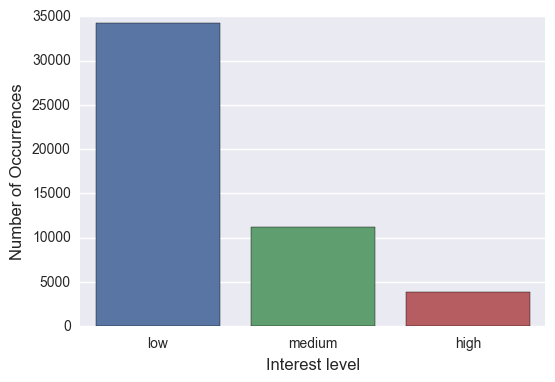

In [4]:
interest_level = trainDF['interest_level'].value_counts()
sns.barplot(interest_level.index, interest_level.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interest level', fontsize=12)
plt.show()

<center> It can clearly be seen that low interest level occurs in most apartments, followed by medium and high respectively. </center>

#### Distribution of Prices

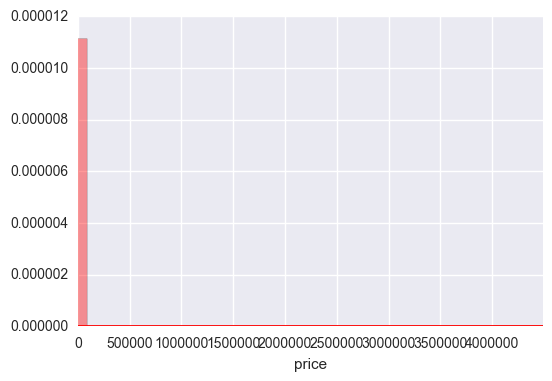

In [5]:
prices = trainDF['price']
sns.distplot(prices, bins=50, kde=True, color='r').set(xlim=(0, max(prices)))
plt.show()

<center> There appears to be some outliers in the price data, let's take a closer look at that. </center>

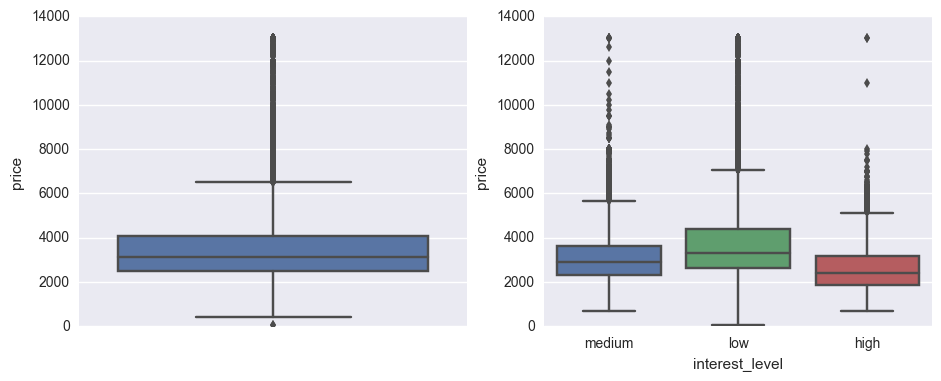

In [6]:
copy = trainDF.copy()
limit = np.percentile(copy.price.values, 99)
copy['price'].ix[copy['price']>limit] = limit
fig, (axes) = plt.subplots(ncols=2)
fig.set_size_inches(11, 4)
sns.boxplot(data=copy,y='price',orient="v", ax=axes[0])
sns.boxplot(data=copy, y="price",x="interest_level",orient="v", ax=axes[1])
plt.show()

<center> As we can see, the price variable defintely contains some outliers on the upper extreme, making our distribution right skewed. When we split the data by interest_level, we can see that most of the skewedness is being cause by the low interest level category. However, given that is where most of our data lies, that isn't too surprising. </center>

</br>

<center> Let's now plot our distribution without the outliers. </center>

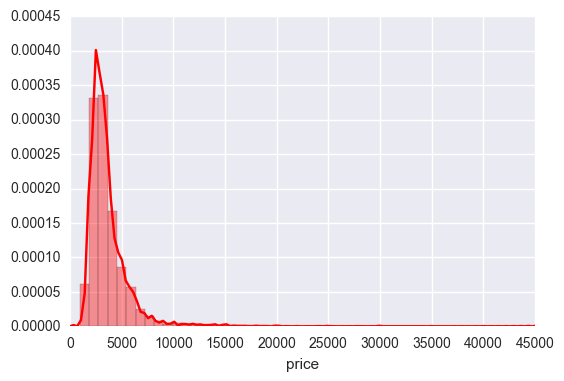

In [7]:
#method to remove outliers
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

prices_without_outliers = reject_outliers(prices)

sns.distplot(prices_without_outliers, bins=50, kde=True, color='r').set(xlim=(0, max(prices_without_outliers)))
plt.show()

#### Average Price Across Price Level

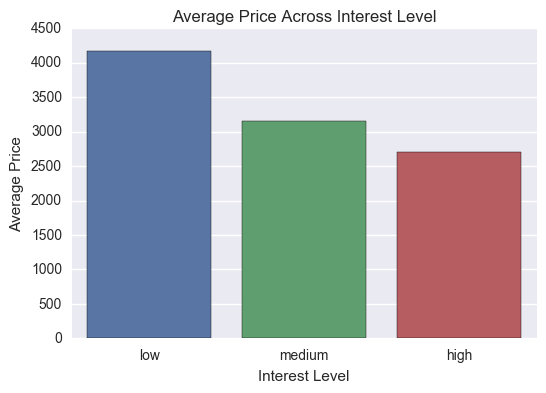

In [8]:
groupedByInterestLevel = pd.DataFrame(trainDF.groupby("interest_level")["price"].mean()).reset_index()
ax = sns.barplot(data=groupedByInterestLevel.sort_values(by="price", ascending = False),x='interest_level', y='price')
ax.set(xlabel='Interest Level', ylabel='Average Price',title="Average Price Across Interest Level")
plt.show()

<center> As we can see, the average price is lower as interest level increases, which is to be expected given that people want cheaper apartments. </center> 

#### Numerical Features

<center> Let's get some 5 number summaries for the other two numerical features, bathrooms and bedrooms, in our dataset. </center>

In [9]:
print("Min Number of Bathrooms: " + str(trainDF["bathrooms"].min()))
print("1st Quartile for Number of Bathrooms: " + str(trainDF["bathrooms"].quantile(.25)))
print("Median Number of Bathrooms: " + str(trainDF["bathrooms"].median()))
print("3rd Quartile for Number of Bathrooms: " + str(trainDF["bathrooms"].quantile(.75)))
print("Max Number of Bathrooms: " + str(trainDF["bathrooms"].max()))
print('\n')
print("Min Number of Bedrooms: " + str(trainDF["bedrooms"].min()))
print("1st Quartile for Number of Bedrooms: " + str(trainDF["bedrooms"].quantile(.25)))
print("Median Number of Bedrooms: " + str(trainDF["bedrooms"].median()))
print("3rd Quartile for Number of Bedrooms: " + str(trainDF["bedrooms"].quantile(.75)))
print("Max Number of Bedrooms: " + str(trainDF["bedrooms"].max()))

Min Number of Bathrooms: 0.0
1st Quartile for Number of Bathrooms: 1.0
Median Number of Bathrooms: 1.0
3rd Quartile for Number of Bathrooms: 1.0
Max Number of Bathrooms: 10.0


Min Number of Bedrooms: 0
1st Quartile for Number of Bedrooms: 1.0
Median Number of Bedrooms: 1.0
3rd Quartile for Number of Bedrooms: 2.0
Max Number of Bedrooms: 8


<center> Looks like we'll likely have some right skewed distributions again. Let's take a look at some ViolinPlots to take a closer look. </center>

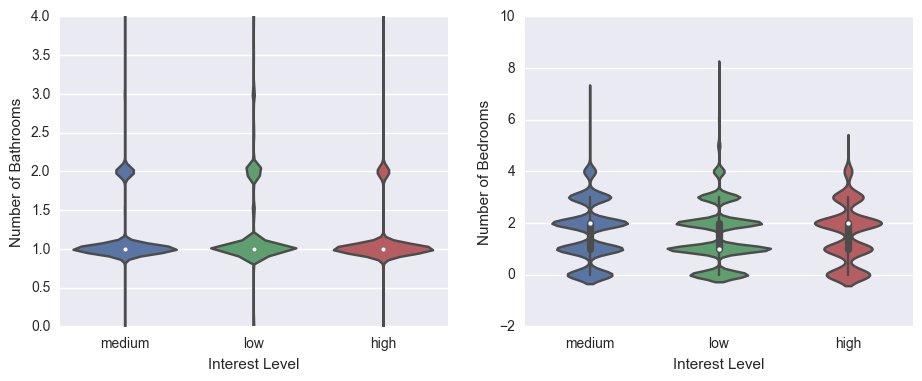

In [10]:
fig, (axes) = plt.subplots(ncols=2)
fig.set_size_inches(11, 4)
sns.violinplot(x='interest_level', y='bathrooms', data=trainDF,ax=axes[0])
axes[0].set(ylim=(0, 4), xlabel='Interest Level', ylabel='Number of Bathrooms')
sns.violinplot(x='interest_level', y='bedrooms', data=trainDF,ax=axes[1])
axes[1].set(xlabel='Interest Level', ylabel='Number of Bedrooms')
plt.show()

<center> The estimated probability densities of both bedrooms and bathrooms across interest level are consistient. Both also seem slightly skewed right. </center> 

#### Latitude and Longitude

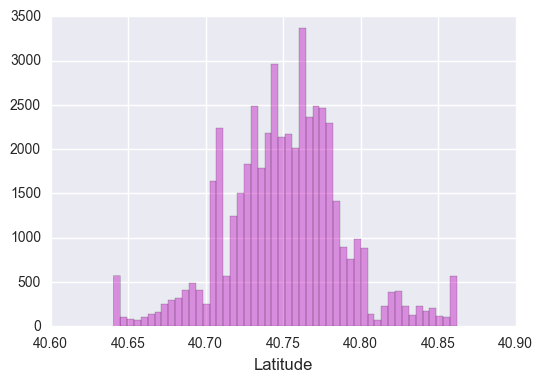

In [11]:
llimit = np.percentile(trainDF.latitude.values, 1)
ulimit = np.percentile(trainDF.latitude.values, 99)
trainDF['latitude'].ix[trainDF['latitude']<llimit] = llimit
trainDF['latitude'].ix[trainDF['latitude']>ulimit] = ulimit

sns.distplot(trainDF.latitude.values, bins=50, color = 'm', kde = False)
plt.xlabel('Latitude', fontsize=12)
plt.show()

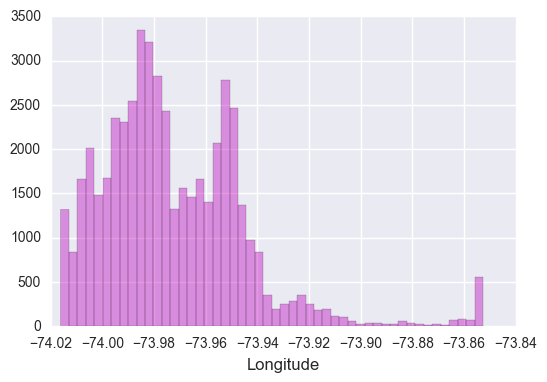

In [13]:
llimit = np.percentile(trainDF.longitude.values, 1)
ulimit = np.percentile(trainDF.longitude.values, 99)
trainDF['longitude'].ix[trainDF['longitude']<llimit] = llimit
trainDF['longitude'].ix[trainDF['longitude']>ulimit] = ulimit

sns.distplot(trainDF.longitude.values, bins=50, color = 'm', kde = False)
plt.xlabel('Longitude', fontsize=12)
plt.show()

<center> It appears that most of our data appears in the [(40.65, 40.85), (-74, -73.8)] range, which corresponds to Long Island in New York City according to http://www.findlatitudeandlongitude.com/. </center>

#### Number of Photos

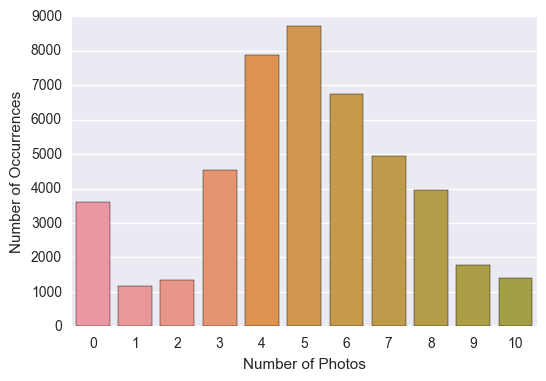

In [18]:
trainDF["num_photos"] = trainDF["photos"].apply(len)
counts = trainDF['num_photos'].value_counts()

sns.barplot(counts.index, counts.values).set(xlim=(-0.5,10.5))
plt.xlabel('Number of Photos')
plt.ylabel('Number of Occurrences')
plt.show()

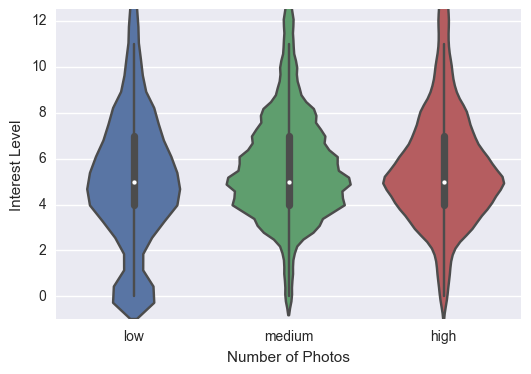

In [22]:
sns.violinplot(x="interest_level", y="num_photos", data=trainDF, order =['low','medium','high']).set(ylim=(-1, 12.5))
plt.xlabel('Number of Photos')
plt.ylabel('Interest Level')
plt.show()

<center> Seems to be maybe a slight trend that the more photos you have, the better chance you have of being more liked. </center>

#### Number of Features

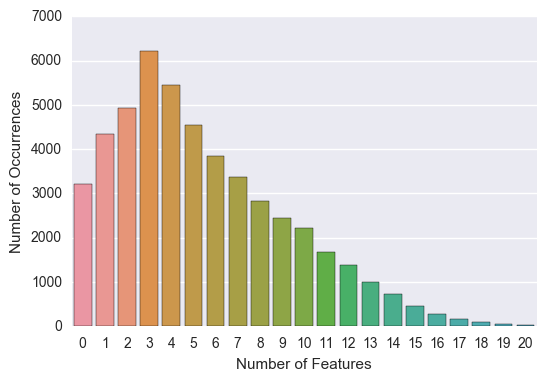

In [25]:
trainDF["num_features"] = trainDF["features"].apply(len)
counts = trainDF['num_features'].value_counts()

sns.barplot(counts.index, counts.values).set(xlim=(-0.5,20.5))
plt.xlabel('Number of Features')
plt.ylabel('Number of Occurrences')
plt.show()

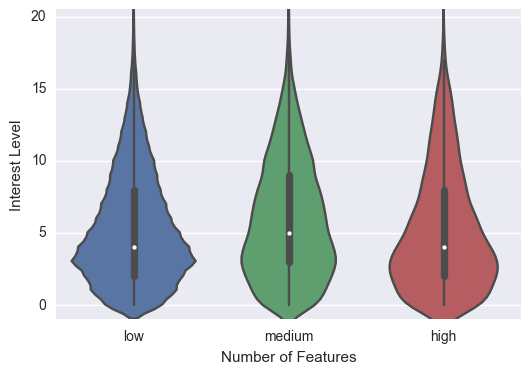

In [26]:
sns.violinplot(x="interest_level", y="num_features", data=trainDF, order =['low','medium','high']).set(ylim=(-1, 20.5))
plt.xlabel('Number of Features')
plt.ylabel('Interest Level')
plt.show()

<center> No apparatent trend that the more features you have, the better chance you have of being more liked. </center>

In [30]:
feature_text = ''
for ind, row in trainDF.iterrows():
    for feature in row['features']:
        feature_text = " ".join([feature_text, "_".join(feature.strip().split(" "))])
feature_text = feature_text.strip()
feature_text.encode('ascii', 'ignore')
feature_text = feature_text.split()

list

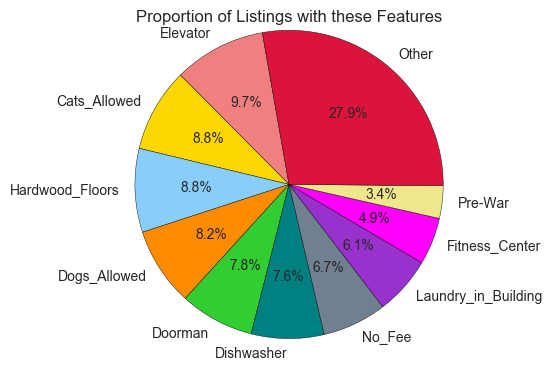

In [52]:
from collections import Counter
from __future__ import division
words_to_count = (word for word in feature_text if word[:1].isupper())
c = Counter(words_to_count)
labels = []
sizes = []
for i in range(0,10):
    labels.append(c.most_common()[i][0])
    sizes.append(c.most_common()[i][1])
labels.append('Other')
sizes.append(len(feature_text) - sum(sizes))
colors = ['lightcoral', 'gold', 'lightskyblue', 'darkorange', 'limegreen', 'teal', 'slategray', 'darkorchid', 'magenta', 'khaki', 'crimson']
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', startangle = 100)
plt.axis('equal')
plt.title('Proportion of Listings with these Features')
plt.show()